In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
#df1 = pd.read_csv("./../../data/dev101_prepared.csv")
#df2 = pd.read_csv("./../../data/dev102_prepared.csv")
df_all = pd.read_csv("data/devAll2_prepared.csv")

In [2]:
#df_all = pd.concat([df1, df2], ignore_index=True)
df_all.describe()

,devID,soil,rain,temp,humi,geo,lat,lng
count,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000,301191.000000
mean,101.503282,48.952394,0.205600,29.871124,75.252266,8.128838,8.637978,99.898949
std,0.499990,10.397376,1.761622,3.193456,8.565651,6.716052,0.000038,0.001335
min,101.000000,21.100000,0.000000,24.238958,43.418247,0.000000,8.637330,99.166664
25%,101.000000,44.200001,0.000000,27.368584,69.429153,3.009754,8.637945,99.898926
50%,102.000000,50.400002,0.000000,28.508812,79.240715,4.383256,8.637974,99.898949
75%,102.000000,57.799999,0.000000,32.749290,81.176704,13.366670,8.638014,99.898972
max,102.000000,66.599998,41.630600,38.984512,88.510567,32.062466,8.638361,99.900078


In [3]:
# Select features

#feature_cols = [
#    'soil', 'rain', 'temp', 'humi', 'geo',
#    'rain_1h_sum', 'rain_3h_sum', 'rain_6h_sum', 'rain_12h_sum', 'rain_1d_sum', 'rain_7d_sum',
#    'soil_1h_mean', 'soil_3h_mean', 'soil_6h_mean', 'soil_12h_mean', 'soil_1d_mean',
#    'geo_1h_mean', 'geo_3h_mean', 'geo_6h_mean', 'geo_12h_mean', 'geo_1d_mean',
#    'soil_diff', 'geo_diff', 'soil_1h_std', 'geo_1h_std'
#]

feature_cols = [
    'soil', 'rain', 'temp', 'humi', 'geo',
]

#feature_cols = [
#    'soil', 'rain', 'temp', 'humi', 'geo',
#    'rain_1h_sum', 'rain_3h_sum', 'rain_6h_sum', 'rain_12h_sum',
#    'soil_1h_mean', 'soil_3h_mean', 'soil_6h_mean', 'soil_12h_mean',
#    'geo_1h_mean', 'geo_3h_mean', 'geo_6h_mean', 'geo_12h_mean',
#]

In [4]:
missing = [col for col in feature_cols if col not in df_all.columns]
if missing:
    raise ValueError(f"ขาดคอลัมน์ในข้อมูลทั้งหมด: {missing}")

In [5]:
df_all

,timestamp,devID,soil,rain,temp,humi,geo,lat,lng
0,2025-05-02 11:42:00.384119,102.0,22.200001,0.0,34.549099,61.175941,3.323395,8.637964,99.898933
1,2025-05-02 11:42:06.635276,101.0,28.799999,0.0,34.290073,62.429081,14.532875,8.637999,99.899010
2,2025-05-02 11:42:11.034615,102.0,22.200001,0.0,34.506374,61.542152,14.766250,8.637963,99.898933
3,2025-05-02 11:42:18.056572,101.0,28.799999,0.0,34.266041,64.082787,14.673310,8.637998,99.899010
4,2025-05-02 11:42:21.675224,102.0,22.200001,0.0,34.485012,61.767223,3.242806,8.637963,99.898933
...,...,...,...,...,...,...,...,...,...
301186,2025-06-29 20:25:27.980,101.0,27.900000,0.0,29.101625,81.113754,2.490953,8.638010,99.898972
301187,2025-06-29 20:25:48.980,102.0,25.600000,0.0,29.908064,77.426796,3.856516,8.637931,99.898941
301188,2025-06-29 20:26:01.100,102.0,25.600000,0.0,29.349968,80.005569,2.614293,8.637931,99.898949
301189,2025-06-29 20:26:02.150,101.0,27.900000,0.0,29.050890,81.302589,8.617684,8.638011,99.898972


In [6]:
# ==== Split Data & Scaling ====

df_train, df_temp = train_test_split(df_all, test_size=0.2, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.35, random_state=42)

print(f"Train: {len(df_train)}, Validation: {len(df_val)}, Test: {len(df_test)}")

# Extract
X_train = df_train[feature_cols].values
X_val = df_val[feature_cols].values
X_test = df_test[feature_cols].values

df_validate_combined = pd.concat([df_val, df_test], ignore_index=True)
df_validate_combined.to_csv("data/validate.csv", index=False)
print(f"validate.csv (rows: {len(df_validate_combined)})")

Train: 240952, Validation: 39155, Test: 21084
validate.csv (rows: 60239)


In [7]:
# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#X_train_scaled = X_train
#X_val_scaled = X_val
#X_test_scaled = X_test

In [8]:
# ==== Train Isolation Forest ====
iso_model = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
iso_model.fit(X_train_scaled)

IsolationForest(contamination=0.03, random_state=42)

In [9]:
# Add anomaly scores
df_train['anomaly_score'] = iso_model.decision_function(X_train_scaled)
df_val['anomaly_score'] = iso_model.decision_function(X_val_scaled)
df_test['anomaly_score'] = iso_model.decision_function(X_test_scaled)

In [10]:

# ==== Thresholds & Risk Level Classification ====

crit_thresh = np.percentile(df_train['anomaly_score'], 0.5)
warn_thresh = np.percentile(df_train['anomaly_score'], 5)

#crit_thresh = -0.11
#warn_thresh = 0.00

def classify_risk(score):
    if score < crit_thresh:
        return "Critical"
    elif score < warn_thresh:
        return "Warning"
    else:
        return "Normal"

for df in [df_train, df_val, df_test]:
    df['risk_level'] = df['anomaly_score'].apply(classify_risk)
print("crit_thresh:", crit_thresh)
print("warn_thresh:", warn_thresh)

crit_thresh: -0.08836725668910894
warn_thresh: 0.025479414819127754


## Validate

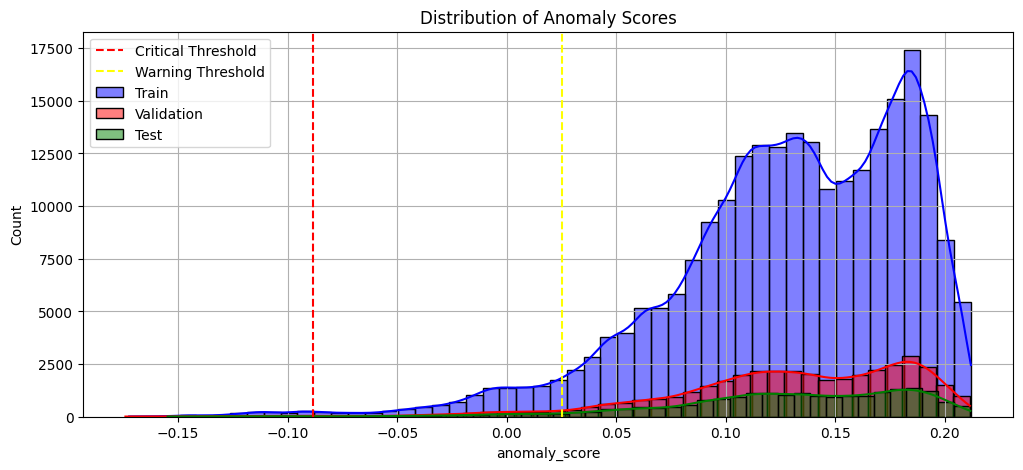

In [11]:
# Distribution of Anomaly Scores

plt.figure(figsize=(12,5))
sns.histplot(df_train['anomaly_score'], bins=50, kde=True, color='blue', label='Train')
sns.histplot(df_val['anomaly_score'], bins=50, kde=True, color='red', label='Validation')
sns.histplot(df_test['anomaly_score'], bins=50, kde=True, color='green', label='Test')
plt.axvline(crit_thresh, color='red', linestyle='--', label='Critical Threshold')
plt.axvline(warn_thresh, color='yellow', linestyle='--', label='Warning Threshold')
plt.title('Distribution of Anomaly Scores')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
print("\n== Risk Proportion ==")
print("Train:", df_train['risk_level'].value_counts(normalize=True))
print("Validation:", df_val['risk_level'].value_counts(normalize=True))
print("Test:", df_test['risk_level'].value_counts(normalize=True))


== Risk Proportion ==
Train: risk_level
Normal      0.949998
Warning     0.045001
Critical    0.005001
Name: proportion, dtype: float64
Validation: risk_level
Normal      0.950530
Warning     0.044005
Critical    0.005465
Name: proportion, dtype: float64
Test: risk_level
Normal      0.950389
Warning     0.044963
Critical    0.004648
Name: proportion, dtype: float64


In [27]:
from joblib import dump
dump(scaler, 'model/iso_scaler.joblib')
dump(iso_model, 'model/iso_model.joblib')

['model/iso_model.joblib']

In [28]:
"""

from joblib import load
scaler = load('scaler.joblib')
model = load('iso_model.joblib')

x_new = scaler.transform([[soil, rain, temp, humi, geo]])
score = model.decision_function(x_new)

if score < -0.2:
    risk = "Critical"
elif score < 0.0:
    risk = "Warning"
else:
    risk = "Normal"
    
    """

'\n\nfrom joblib import load\nscaler = load(\'scaler.joblib\')\nmodel = load(\'iso_model.joblib\')\n\nx_new = scaler.transform([[soil, rain, temp, humi, geo]])\nscore = model.decision_function(x_new)\n\nif score < -0.2:\n    risk = "Critical"\nelif score < 0.0:\n    risk = "Warning"\nelse:\n    risk = "Normal"\n    \n    '